In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import lime
import re
from collections import Counter

In [67]:
df1 = pd.read_csv("student-mat.csv",sep=";")
df2 = pd.read_csv("student-por.csv",sep=";")
id_cols = [
    "school", "sex", "age", "address", "famsize", "Pstatus",
    "Medu", "Fedu", "Mjob", "Fjob", "reason", "nursery", "internet"
]

df = pd.merge(df1, df2, on=id_cols, how="outer", suffixes=("_math", "_por"))
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel_por,freetime_por,goout_por,Dalc_por,Walc_por,health_por,absences_por,G1_por,G2_por,G3_por
0,GP,F,15,R,GT3,T,1,1,at_home,other,...,3.0,1.0,2.0,1.0,1.0,1.0,4.0,13.0,13.0,13.0
1,GP,F,15,R,GT3,T,1,1,other,other,...,5.0,5.0,5.0,1.0,1.0,1.0,2.0,8.0,9.0,9.0
2,GP,F,15,R,GT3,T,1,1,other,other,...,3.0,3.0,4.0,2.0,4.0,5.0,2.0,13.0,11.0,11.0
3,GP,F,15,R,GT3,T,2,2,at_home,other,...,4.0,3.0,1.0,1.0,1.0,2.0,8.0,14.0,13.0,12.0
4,GP,F,15,R,GT3,T,2,4,services,health,...,4.0,3.0,2.0,1.0,1.0,5.0,2.0,10.0,11.0,10.0


In [68]:
print(df.shape)
print(df.info())
print(df.describe())
print(df.isnull().sum())

(682, 53)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school           682 non-null    object 
 1   sex              682 non-null    object 
 2   age              682 non-null    int64  
 3   address          682 non-null    object 
 4   famsize          682 non-null    object 
 5   Pstatus          682 non-null    object 
 6   Medu             682 non-null    int64  
 7   Fedu             682 non-null    int64  
 8   Mjob             682 non-null    object 
 9   Fjob             682 non-null    object 
 10  reason           682 non-null    object 
 11  guardian_math    407 non-null    object 
 12  traveltime_math  407 non-null    float64
 13  studytime_math   407 non-null    float64
 14  failures_math    407 non-null    float64
 15  schoolsup_math   407 non-null    object 
 16  famsup_math      407 non-null    object 
 17  paid_m

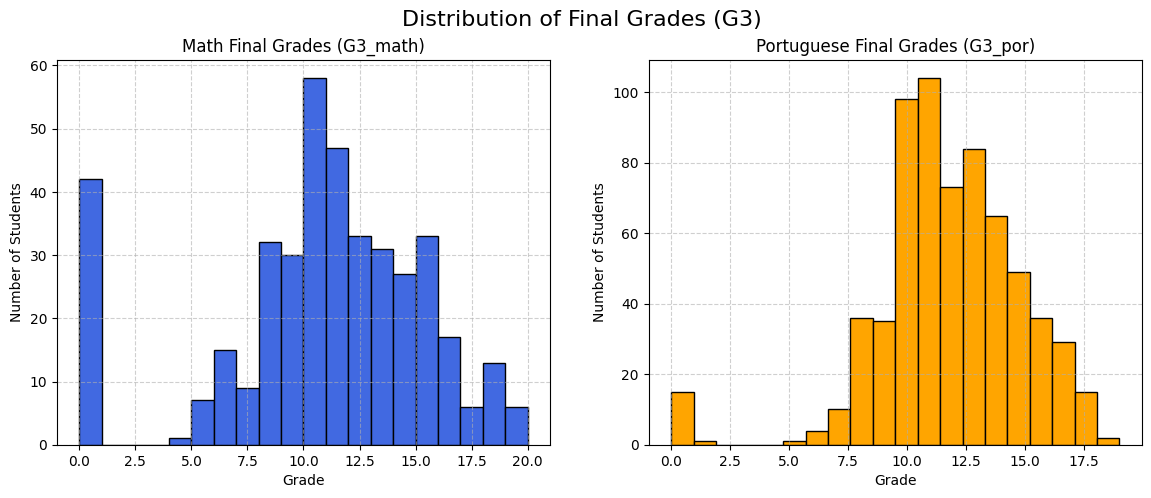

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Distribution of Final Grades (G3)', fontsize=16)

# Plot for Math grades
ax1.hist(df['G3_math'].dropna(), bins=20, color='royalblue', edgecolor='black')
ax1.set_title('Math Final Grades (G3_math)')
ax1.set_xlabel('Grade')
ax1.set_ylabel('Number of Students')
ax1.grid(True, linestyle='--', alpha=0.6)


# Plot for Portuguese grades
ax2.hist(df['G3_por'].dropna(), bins=20, color='orange', edgecolor='black')
ax2.set_title('Portuguese Final Grades (G3_por)')
ax2.set_xlabel('Grade')
ax2.set_ylabel('Number of Students')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.show()

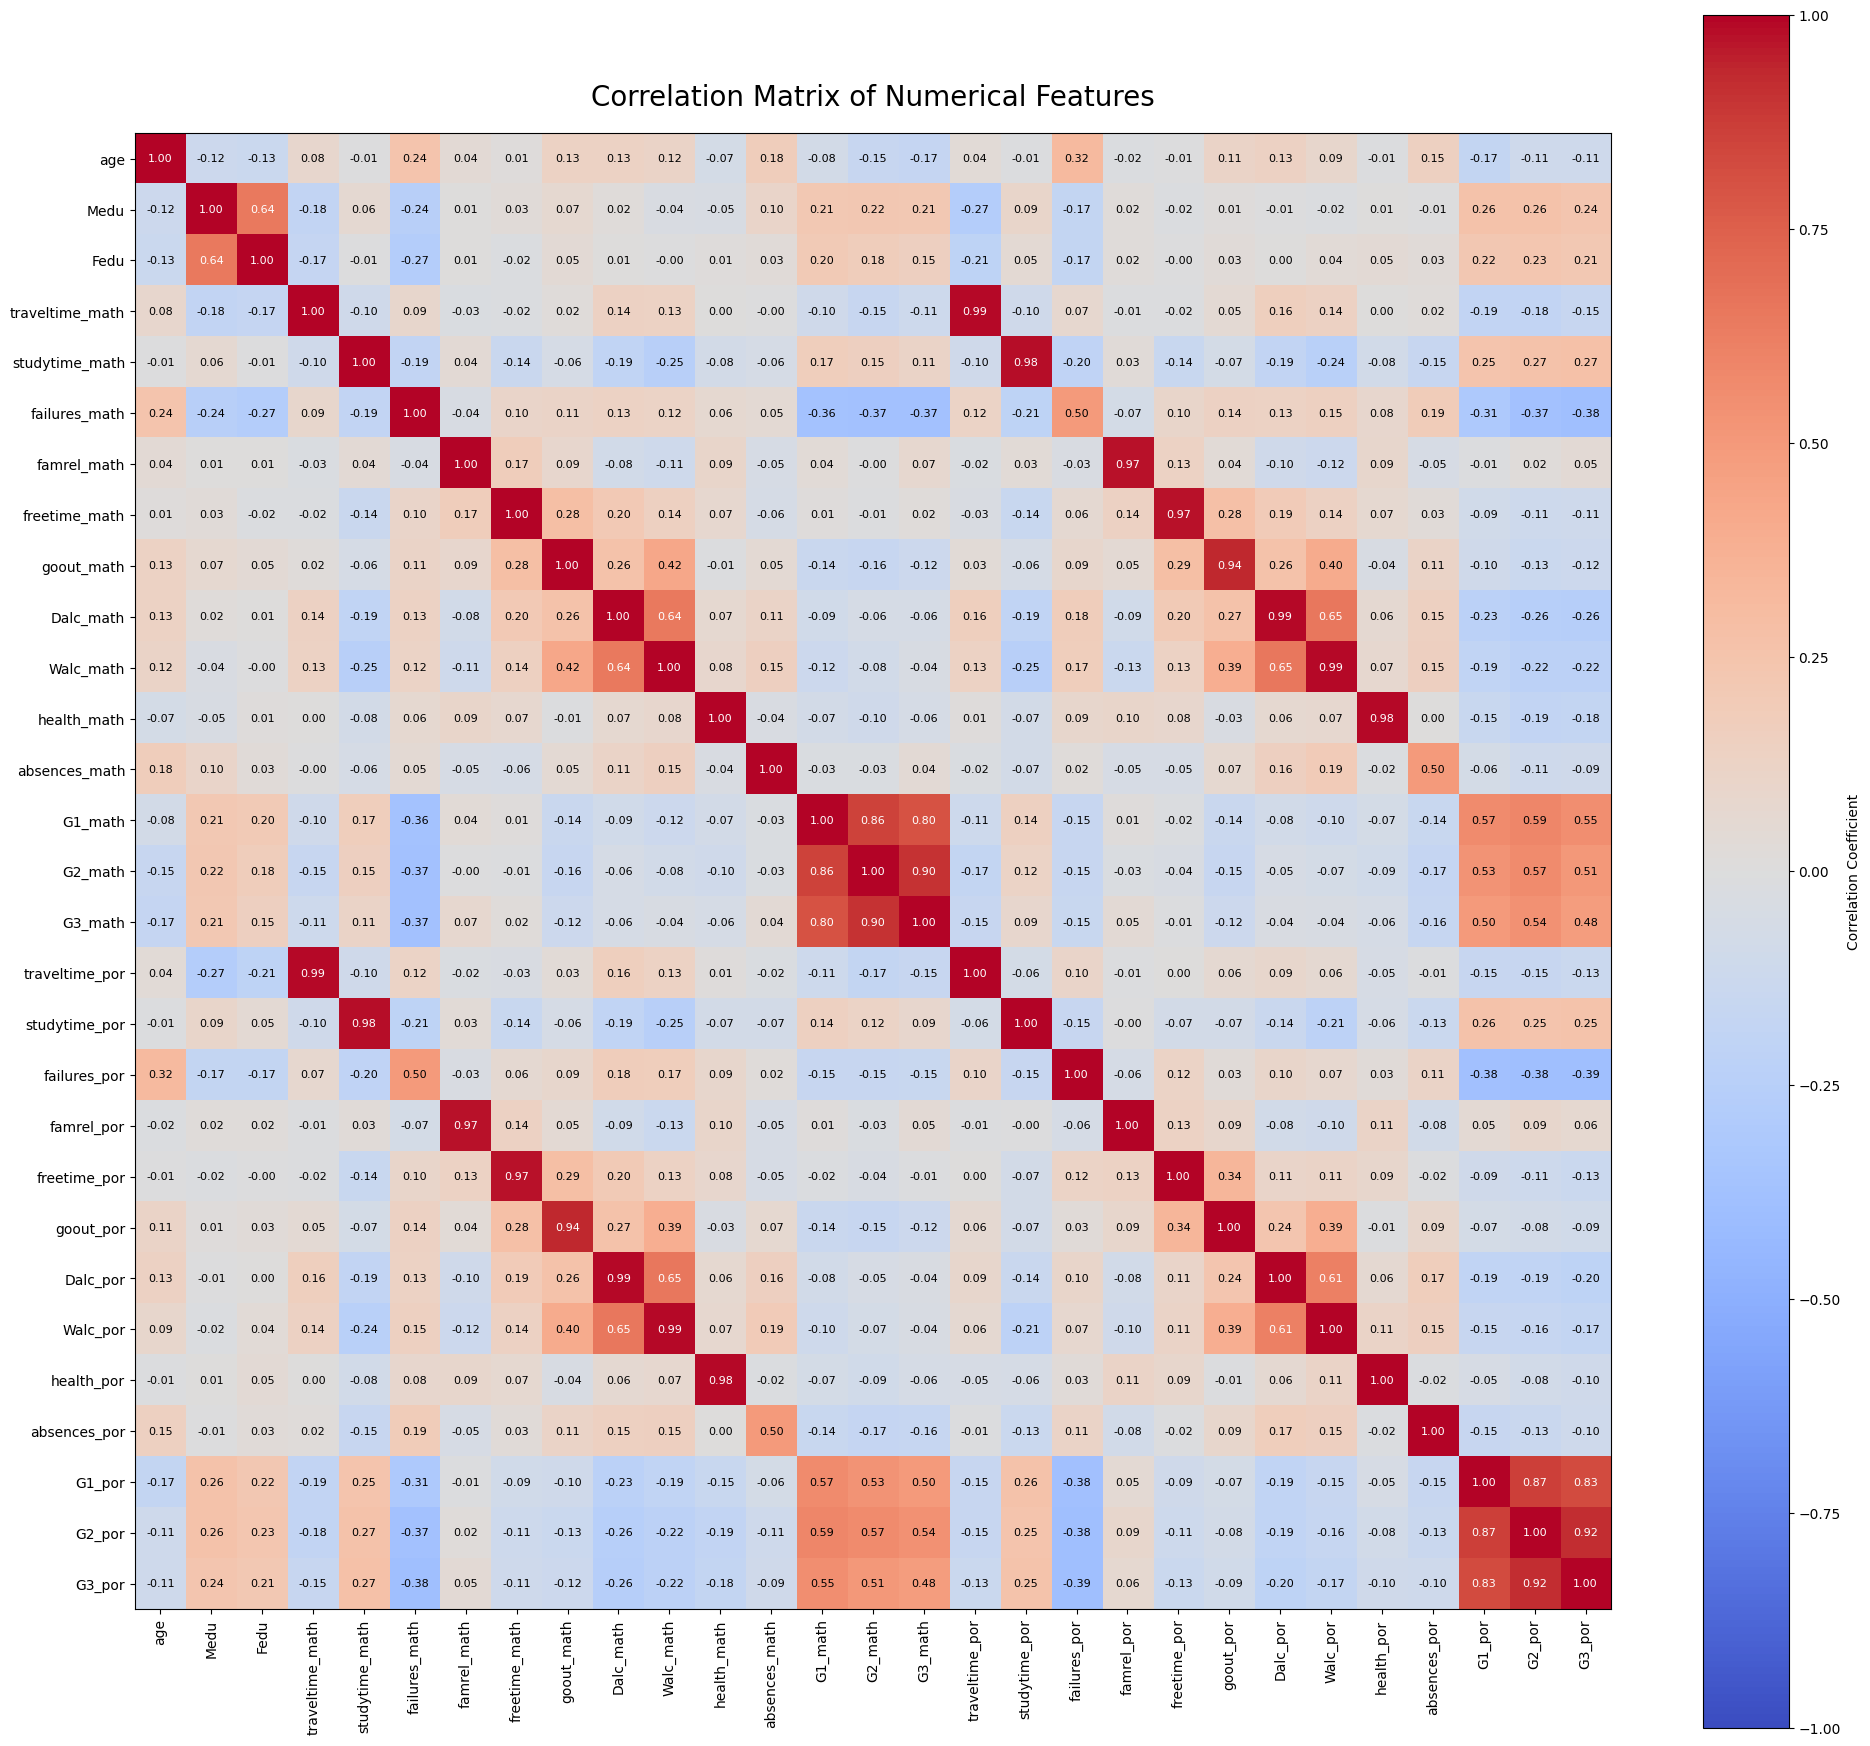

In [70]:
correlation_matrix = df.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 18))

cax = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

fig.colorbar(cax, label='Correlation Coefficient')

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        value = correlation_matrix.iloc[i, j]
        text_color = "white" if abs(value) > 0.6 else "black"
        ax.text(j, i, f'{value:.2f}',
                ha="center", va="center", color=text_color, fontsize=8)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.columns)

ax.set_title('Correlation Matrix of Numerical Features', fontsize=20, pad=20)
plt.tight_layout() 
plt.show()

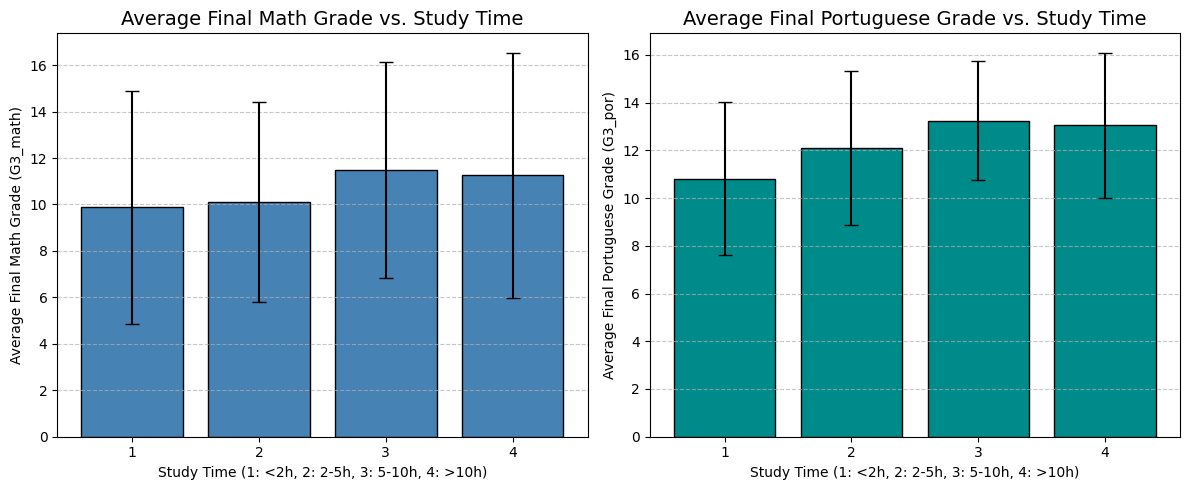

In [71]:
study_math_mean = df.groupby('studytime_math')['G3_math'].mean()
study_por_mean  = df.groupby('studytime_por')['G3_por'].mean()

study_math_std = df.groupby('studytime_math')['G3_math'].std()
study_por_std  = df.groupby('studytime_por')['G3_por'].std()

plt.figure(figsize=(12, 5))

# Math plot
plt.subplot(1, 2, 1)
plt.bar(study_math_mean.index, study_math_mean.values, 
        yerr=study_math_std.values, capsize=5,
        color='steelblue', edgecolor='black')
plt.title('Average Final Math Grade vs. Study Time', fontsize=14)
plt.xlabel('Study Time (1: <2h, 2: 2-5h, 3: 5-10h, 4: >10h)')
plt.ylabel('Average Final Math Grade (G3_math)')
plt.xticks(study_math_mean.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Portuguese plot
plt.subplot(1, 2, 2)
plt.bar(study_por_mean.index, study_por_mean.values, 
        yerr=study_por_std.values, capsize=5,
        color='darkcyan', edgecolor='black')
plt.title('Average Final Portuguese Grade vs. Study Time', fontsize=14)
plt.xlabel('Study Time (1: <2h, 2: 2-5h, 3: 5-10h, 4: >10h)')
plt.ylabel('Average Final Portuguese Grade (G3_por)')
plt.xticks(study_por_mean.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

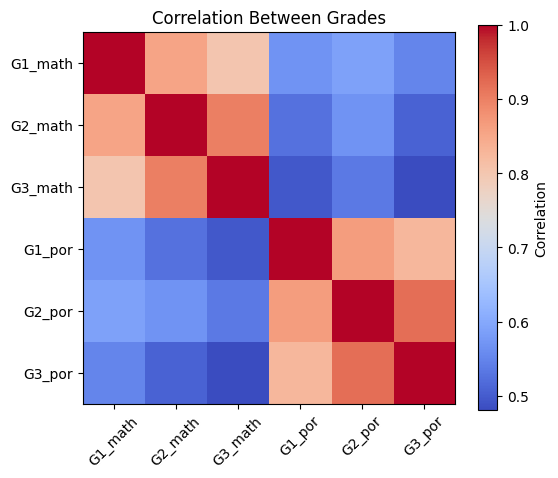

In [72]:
grade_cols = ['G1_math','G2_math','G3_math','G1_por','G2_por','G3_por']
corr = df[grade_cols].corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")
plt.xticks(range(len(grade_cols)), grade_cols, rotation=45)
plt.yticks(range(len(grade_cols)), grade_cols)
plt.title("Correlation Between Grades")
plt.show()


In [73]:
df = df.drop(["reason", "guardian_math", "guardian_por"], axis=1)
print(df.shape)

(682, 50)


In [74]:
df.isnull().sum()

school               0
sex                  0
age                  0
address              0
famsize              0
Pstatus              0
Medu                 0
Fedu                 0
Mjob                 0
Fjob                 0
traveltime_math    275
studytime_math     275
failures_math      275
schoolsup_math     275
famsup_math        275
paid_math          275
activities_math    275
nursery              0
higher_math        275
internet             0
romantic_math      275
famrel_math        275
freetime_math      275
goout_math         275
Dalc_math          275
Walc_math          275
health_math        275
absences_math      275
G1_math            275
G2_math            275
G3_math            275
traveltime_por      25
studytime_por       25
failures_por        25
schoolsup_por       25
famsup_por          25
paid_por            25
activities_por      25
higher_por          25
romantic_por        25
famrel_por          25
freetime_por        25
goout_por           25
Dalc_por   

In [75]:
# Fill missing values for numerical columns with mean or mode
df['traveltime_math'] = df['traveltime_math'].fillna(df['traveltime_math'].mean())
df['traveltime_por'] = df['traveltime_por'].fillna(df['traveltime_por'].mean())
df['studytime_math'] = df['studytime_math'].fillna(df['studytime_math'].mean())
df['studytime_por'] = df['studytime_por'].fillna(df['studytime_por'].mean())
df['failures_math'] = df['failures_math'].fillna(df['failures_math'].mode()[0])
df['failures_por'] = df['failures_por'].fillna(df['failures_por'].mode()[0])
df['famrel_math'] = df['famrel_math'].fillna(df['famrel_math'].mean())
df['famrel_por'] = df['famrel_por'].fillna(df['famrel_por'].mean())
df['freetime_math'] = df['freetime_math'].fillna(df['freetime_math'].mean())
df['freetime_por'] = df['freetime_por'].fillna(df['freetime_por'].mean())
df['goout_math'] = df['goout_math'].fillna(df['goout_math'].mean())
df['goout_por'] = df['goout_por'].fillna(df['goout_por'].mean())
df['Dalc_math'] = df['Dalc_math'].fillna(df['Dalc_math'].mode()[0])
df['Dalc_por'] = df['Dalc_por'].fillna(df['Dalc_por'].mode()[0])
df['Walc_math'] = df['Walc_math'].fillna(df['Walc_math'].mode()[0])
df['Walc_por'] = df['Walc_por'].fillna(df['Walc_por'].mode()[0])
df['health_math'] = df['health_math'].fillna(df['health_math'].mean())
df['health_por'] = df['health_por'].fillna(df['health_por'].mean())
df['absences_math'] = df['absences_math'].fillna(df['absences_math'].mean())
df['absences_por'] = df['absences_por'].fillna(df['absences_por'].mean())
df['G1_math'] = df['G1_math'].fillna(df['G1_math'].mean())
df['G1_por'] = df['G1_por'].fillna(df['G1_por'].mean())
df['G2_math'] = df['G2_math'].fillna(df['G2_math'].mean())
df['G2_por'] = df['G2_por'].fillna(df['G2_por'].mean())
df['G3_math'] = df['G3_math'].fillna(df['G3_math'].mean())
df['G3_por'] = df['G3_por'].fillna(df['G3_por'].mean())

df['schoolsup_math'] = df['schoolsup_math'].fillna('Unknown')
df['schoolsup_por'] = df['schoolsup_por'].fillna('Unknown')
df['famsup_math'] = df['famsup_math'].fillna('Unknown')
df['famsup_por'] = df['famsup_por'].fillna('Unknown')
df['paid_math'] = df['paid_math'].fillna('Unknown')
df['paid_por'] = df['paid_por'].fillna('Unknown')
df['activities_math'] = df['activities_math'].fillna('Unknown')
df['activities_por'] = df['activities_por'].fillna('Unknown')
df['higher_math'] = df['higher_math'].fillna('Unknown')
df['higher_por'] = df['higher_por'].fillna('Unknown')
df['romantic_math'] = df['romantic_math'].fillna('Unknown')
df['romantic_por'] = df['romantic_por'].fillna('Unknown')

df.isnull().sum()

school             0
sex                0
age                0
address            0
famsize            0
Pstatus            0
Medu               0
Fedu               0
Mjob               0
Fjob               0
traveltime_math    0
studytime_math     0
failures_math      0
schoolsup_math     0
famsup_math        0
paid_math          0
activities_math    0
nursery            0
higher_math        0
internet           0
romantic_math      0
famrel_math        0
freetime_math      0
goout_math         0
Dalc_math          0
Walc_math          0
health_math        0
absences_math      0
G1_math            0
G2_math            0
G3_math            0
traveltime_por     0
studytime_por      0
failures_por       0
schoolsup_por      0
famsup_por         0
paid_por           0
activities_por     0
higher_por         0
romantic_por       0
famrel_por         0
freetime_por       0
goout_por          0
Dalc_por           0
Walc_por           0
health_por         0
absences_por       0
G1_por       

In [76]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['school', 'sex', 'address', 'famsize', 'Pstatus',
                           'Mjob', 'Fjob', 'schoolsup_math', 'schoolsup_por',
                           'famsup_math', 'famsup_por', 'paid_math', 'paid_por',
                           'activities_math', 'activities_por', 'nursery',
                           'higher_math', 'higher_por', 'internet', 'romantic_math',
                           'romantic_por'], drop_first=True)
print(df.shape)

(682, 68)


In [77]:
#df.to_csv("student_data_cleaned.csv", index=False)

In [78]:
X = df.drop(['G1_math', 'G2_math', 'G3_math', 'G1_por', 'G2_por', 'G3_por'], axis=1)
target_columns = ['G1_math', 'G2_math', 'G3_math', 'G1_por', 'G2_por', 'G3_por']
print("Shape of features (X):", X.shape)
y = df[target_columns]
print("Shape of target (y):", y.shape)

Shape of features (X): (682, 62)
Shape of target (y): (682, 6)


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Initialize the ColumnTransformer with StandardScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print("--- Scaling Information ---")
print("Number of features being scaled:", len(numerical_features))
print("Shape of scaled training features:", X_train_scaled.shape)
print("Shape of scaled testing features:", X_test_scaled.shape)

--- Scaling Information ---
Number of features being scaled: 23
Shape of scaled training features: (545, 62)
Shape of scaled testing features: (137, 62)


In [80]:
# Decision Tree for Multi-Output Regression
multi_output_tree = DecisionTreeRegressor(random_state=42)
multi_output_tree.fit(X_train_scaled, y_train)
y_pred_tree = multi_output_tree.predict(X_test_scaled)

avg_mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Average MSE across all 6 grades (Decision Tree): {avg_mse_tree:.4f}")

avg_r2_tree = r2_score(y_test, y_pred_tree)
print(f"Average R² Score across all 6 grades (Decision Tree): {avg_r2_tree:.4f}")

raw_mse_tree = mean_squared_error(y_test, y_pred_tree, multioutput='raw_values')
raw_r2_tree = r2_score(y_test, y_pred_tree, multioutput='raw_values')

print("--- Decision Tree Performance (per Grade) ---")
for i, grade_name in enumerate(y_test.columns):
    print(f"Target: {grade_name}")
    print(f"  - MSE: {raw_mse_tree[i]:.4f}")
    print(f"  - R² Score: {raw_r2_tree[i]:.4f}\n")

Average MSE across all 6 grades (Decision Tree): 12.4839
Average R² Score across all 6 grades (Decision Tree): -0.6021
--- Decision Tree Performance (per Grade) ---
Target: G1_math
  - MSE: 11.1280
  - R² Score: -0.7633

Target: G2_math
  - MSE: 14.8549
  - R² Score: -0.6122

Target: G3_math
  - MSE: 17.9956
  - R² Score: -0.4587

Target: G1_por
  - MSE: 10.6320
  - R² Score: -0.7933

Target: G2_por
  - MSE: 8.4753
  - R² Score: -0.3733

Target: G3_por
  - MSE: 11.8178
  - R² Score: -0.6117



In [81]:
#Random Forest Regressor for Multi-Output Regression
multi_output_forest = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
multi_output_forest.fit(X_train_scaled, y_train)
y_pred = multi_output_forest.predict(X_test_scaled)
avg_mse = mean_squared_error(y_test, y_pred)
print(f"Average MSE across all 6 grades: {avg_mse:.4f}")

avg_r2 = r2_score(y_test, y_pred)
print(f"Average R² Score across all 6 grades: {avg_r2:.4f}")

raw_mse_rf = mean_squared_error(y_test, y_pred, multioutput='raw_values')
raw_r2_rf = r2_score(y_test, y_pred, multioutput='raw_values')
print("--- Random Forest Performance (per Grade) ---")
for i, grade_name in enumerate(y_test.columns):
    print(f"Target: {grade_name}")
    print(f"  - MSE: {raw_mse_rf[i]:.4f}")
    print(f"  - R² Score: {raw_r2_rf[i]:.4f}\n")

Average MSE across all 6 grades: 5.9606
Average R² Score across all 6 grades: 0.2497
--- Random Forest Performance (per Grade) ---
Target: G1_math
  - MSE: 4.8071
  - R² Score: 0.2383

Target: G2_math
  - MSE: 7.5209
  - R² Score: 0.1838

Target: G3_math
  - MSE: 9.4376
  - R² Score: 0.2350

Target: G1_por
  - MSE: 4.2381
  - R² Score: 0.2851

Target: G2_por
  - MSE: 4.4132
  - R² Score: 0.2849

Target: G3_por
  - MSE: 5.3467
  - R² Score: 0.2708



In [82]:
# Linear Regression for Multi-Output Regression
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

avg_mse_lr = mean_squared_error(y_test, y_pred_lr)
avg_r2_lr = r2_score(y_test, y_pred_lr)
print(f"Average MSE across all 6 grades (Linear Regression): {avg_mse_lr:.4f}")
print(f"Average R² Score across all 6 grades (Linear Regression): {avg_r2_lr:.4f}")

mse_per_task_lr = mean_squared_error(y_test, y_pred_lr, multioutput='raw_values')
r2_per_task_lr = r2_score(y_test, y_pred_lr, multioutput='raw_values')

print("--- Linear Regression Performance (per Grade) ---")
for i, grade_name in enumerate(y_test.columns):
    print(f"Target: {grade_name}")
    print(f"  - MSE: {mse_per_task_lr[i]:.4f}")
    print(f"  - R² Score: {r2_per_task_lr[i]:.4f}\n")

Average MSE across all 6 grades (Linear Regression): 6.5770
Average R² Score across all 6 grades (Linear Regression): 0.1807
--- Linear Regression Performance (per Grade) ---
Target: G1_math
  - MSE: 5.2080
  - R² Score: 0.1748

Target: G2_math
  - MSE: 7.5768
  - R² Score: 0.1777

Target: G3_math
  - MSE: 11.6691
  - R² Score: 0.0541

Target: G1_por
  - MSE: 4.5353
  - R² Score: 0.2350

Target: G2_por
  - MSE: 5.0419
  - R² Score: 0.1830

Target: G3_por
  - MSE: 5.4306
  - R² Score: 0.2594



In [83]:
# Support Vector Regression (SVR) for Multi-Output Regression
svr = SVR()
# This will train 6 separate SVR models, one for each grade.
multi_output_svr = MultiOutputRegressor(svr, n_jobs=-1)

# Fit the wrapper on the scaled training data. It will handle fitting all 6 SVR models.
multi_output_svr.fit(X_train_scaled, y_train)
y_pred_svr = multi_output_svr.predict(X_test_scaled)

avg_mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"\nAverage MSE across all 6 grades (SVR): {avg_mse_svr:.4f}")

avg_r2_svr = r2_score(y_test, y_pred_svr)
print(f"Average R² Score across all 6 grades (SVR): {avg_r2_svr:.4f}")

raw_mse_svr = mean_squared_error(y_test, y_pred_svr, multioutput='raw_values')
raw_r2_svr = r2_score(y_test, y_pred_svr, multioutput='raw_values')

print("--- SVR Performance (per Grade) ---")
for i, grade_name in enumerate(y_test.columns):
    print(f"Target: {grade_name}")
    print(f"  - MSE: {raw_mse_svr[i]:.4f}")
    print(f"  - R² Score: {raw_r2_svr[i]:.4f}\n")


Average MSE across all 6 grades (SVR): 6.5853
Average R² Score across all 6 grades (SVR): 0.1834
--- SVR Performance (per Grade) ---
Target: G1_math
  - MSE: 5.5392
  - R² Score: 0.1223

Target: G2_math
  - MSE: 8.2144
  - R² Score: 0.1085

Target: G3_math
  - MSE: 11.4881
  - R² Score: 0.0688

Target: G1_por
  - MSE: 4.1535
  - R² Score: 0.2994

Target: G2_por
  - MSE: 4.6238
  - R² Score: 0.2508

Target: G3_por
  - MSE: 5.4927
  - R² Score: 0.2509



In [84]:
# Neural Network (MLPRegressor) for Multi-Output Regression
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50),
                         max_iter=1000,
                         random_state=42,
                         early_stopping=True)

mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)

avg_mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f"\nAverage MSE across all 6 grades (Neural Network): {avg_mse_mlp:.4f}")

avg_r2_mlp = r2_score(y_test, y_pred_mlp)
print(f"Average R² Score across all 6 grades (Neural Network): {avg_r2_mlp:.4f}")

raw_mse_mlp = mean_squared_error(y_test, y_pred_mlp, multioutput='raw_values')
raw_r2_mlp = r2_score(y_test, y_pred_mlp, multioutput='raw_values')

print("--- Neural Network Performance (per Grade) ---")
for i, grade_name in enumerate(y_test.columns):
    print(f"Target: {grade_name}")
    print(f"  - MSE: {raw_mse_mlp[i]:.4f}")
    print(f"  - R² Score: {raw_r2_mlp[i]:.4f}\n")


Average MSE across all 6 grades (Neural Network): 7.0075
Average R² Score across all 6 grades (Neural Network): 0.1200
--- Neural Network Performance (per Grade) ---
Target: G1_math
  - MSE: 5.7126
  - R² Score: 0.0948

Target: G2_math
  - MSE: 7.8109
  - R² Score: 0.1523

Target: G3_math
  - MSE: 11.9060
  - R² Score: 0.0349

Target: G1_por
  - MSE: 4.8796
  - R² Score: 0.1769

Target: G2_por
  - MSE: 5.3882
  - R² Score: 0.1269

Target: G3_por
  - MSE: 6.3478
  - R² Score: 0.1343



In [85]:
# Manual Voting Ensemble using the predictions from Linear Regression, Random Forest, and SVR
all_predictions = [
    y_pred_lr,
    y_pred,
    y_pred_svr
]

weights = [0.2, 0.6, 0.2]
y_pred_weighted_voting = np.average(all_predictions, axis=0, weights=weights)

avg_mse_manual_voting = mean_squared_error(y_test, y_pred_weighted_voting)
print(f"Average MSE across all 6 grades (Manual Voting): {avg_mse_manual_voting:.4f}")

avg_r2_manual_voting = r2_score(y_test, y_pred_weighted_voting)
print(f"Average R² Score across all 6 grades (Manual Voting): {avg_r2_manual_voting:.4f}\n")

raw_mse_manual_voting = mean_squared_error(y_test, y_pred_weighted_voting, multioutput='raw_values')
raw_r2_manual_voting = r2_score(y_test, y_pred_weighted_voting, multioutput='raw_values')

print("--- Manual Voting using the predictions from Linear Regression, Random Forest, and SVR Ensemble Performance (per Grade) ---")
for i, grade_name in enumerate(y_test.columns):
    print(f"Target: {grade_name}")
    print(f"  - MSE: {raw_mse_manual_voting[i]:.4f}")
    print(f"  - R² Score: {raw_r2_manual_voting[i]:.4f}\n")

Average MSE across all 6 grades (Manual Voting): 5.8615
Average R² Score across all 6 grades (Manual Voting): 0.2657

--- Manual Voting using the predictions from Linear Regression, Random Forest, and SVR Ensemble Performance (per Grade) ---
Target: G1_math
  - MSE: 4.7420
  - R² Score: 0.2486

Target: G2_math
  - MSE: 7.3478
  - R² Score: 0.2026

Target: G3_math
  - MSE: 9.6404
  - R² Score: 0.2186

Target: G1_por
  - MSE: 4.0426
  - R² Score: 0.3181

Target: G2_por
  - MSE: 4.3683
  - R² Score: 0.2922

Target: G3_por
  - MSE: 5.0280
  - R² Score: 0.3143



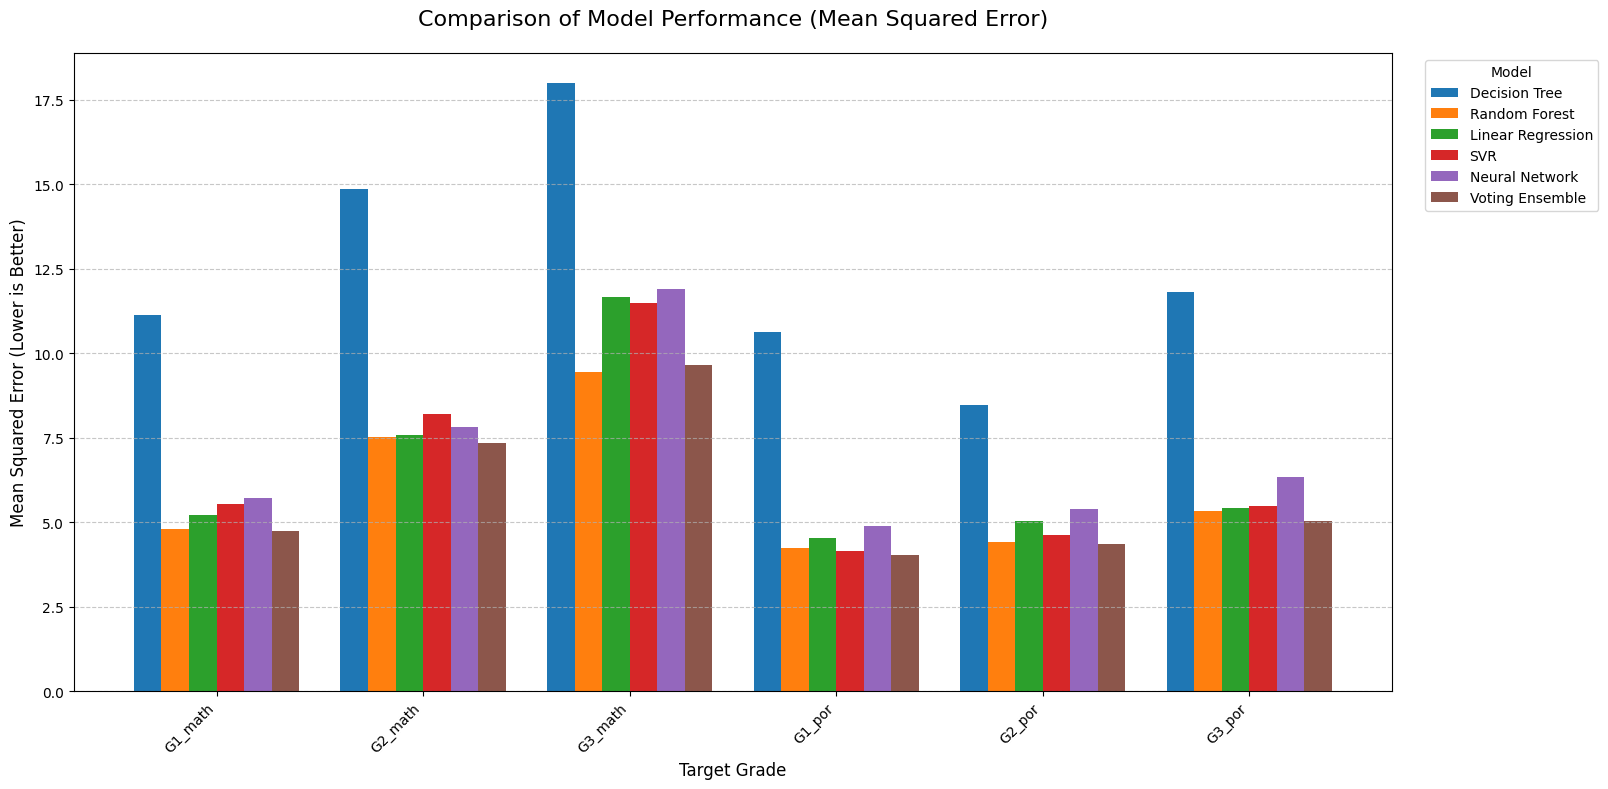

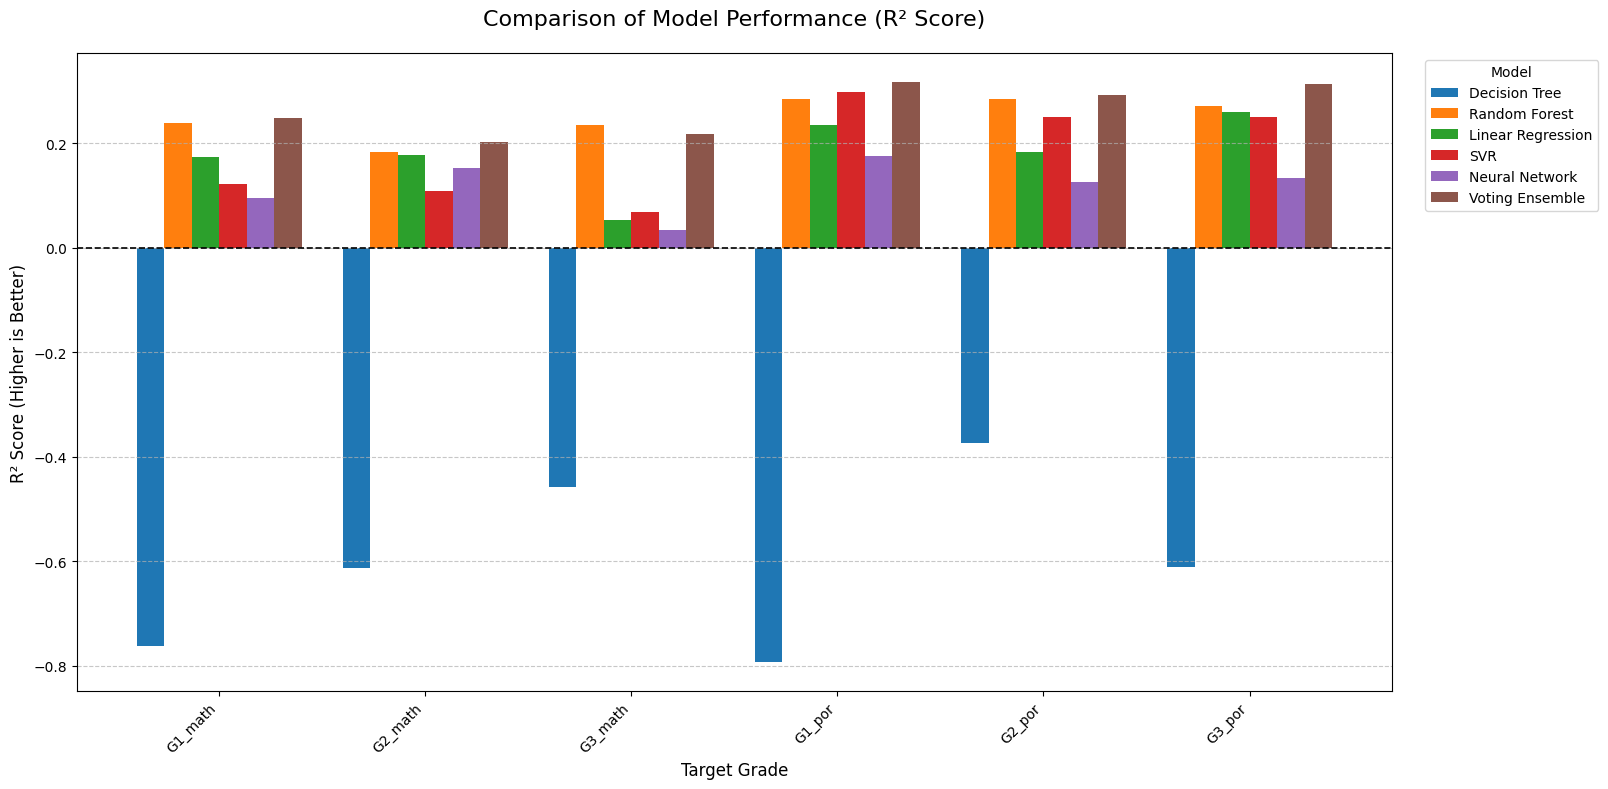

In [86]:
# Graphical Comparison of Model Performance
model_scores = {
    'Decision Tree': {'mse': raw_mse_tree, 'r2': raw_r2_tree},
    'Random Forest': {'mse': raw_mse_rf, 'r2': raw_r2_rf},
    'Linear Regression': {'mse': mse_per_task_lr, 'r2': r2_per_task_lr},
    'SVR': {'mse': raw_mse_svr, 'r2': raw_r2_svr},
    'Neural Network': {'mse': raw_mse_mlp, 'r2': raw_r2_mlp},
    'Voting Ensemble': {'mse': raw_mse_manual_voting, 'r2': raw_r2_manual_voting}
}

model_names = list(model_scores.keys())
target_names = y_test.columns
num_models = len(model_names)
num_targets = len(target_names)

fig, ax1 = plt.subplots(figsize=(18, 8))

bar_width = 0.8 / num_models
index = np.arange(num_targets)

# Loop through each model and plot its bars
for i, model_name in enumerate(model_names):
    position = index + (i - (num_models - 1) / 2) * bar_width
    
    mse_values = model_scores[model_name]['mse']
    ax1.bar(position, mse_values, bar_width, label=model_name)

# Add labels, title, and legend
ax1.set_title('Comparison of Model Performance (Mean Squared Error)', fontsize=16, pad=20)
ax1.set_ylabel('Mean Squared Error (Lower is Better)', fontsize=12)
ax1.set_xlabel('Target Grade', fontsize=12)
ax1.set_xticks(index)
ax1.set_xticklabels(target_names, rotation=45, ha='right')
ax1.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


fig, ax2 = plt.subplots(figsize=(18, 8))

# Loop through each model again to plot R² scores
for i, model_name in enumerate(model_names):
    position = index + (i - (num_models - 1) / 2) * bar_width
    
    r2_values = model_scores[model_name]['r2']
    ax2.bar(position, r2_values, bar_width, label=model_name)

ax2.axhline(0, color='black', linewidth=1.2, linestyle='--')

ax2.set_title('Comparison of Model Performance (R² Score)', fontsize=16, pad=20)
ax2.set_ylabel('R² Score (Higher is Better)', fontsize=12)
ax2.set_xlabel('Target Grade', fontsize=12)
ax2.set_xticks(index)
ax2.set_xticklabels(target_names, rotation=45, ha='right')
ax2.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

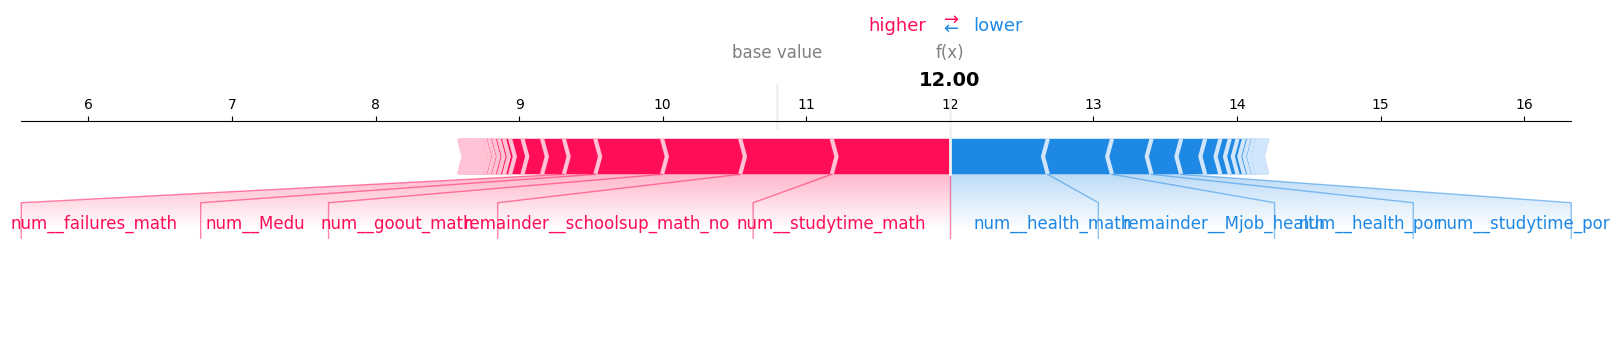

In [87]:
# SHAP Explanation for Random Forest Model on G3_math
target_names = y_test.columns
g3_math_index = list(target_names).index('G3_math')

g3_math_model = multi_output_forest.estimators_[g3_math_index]

explainer = shap.TreeExplainer(g3_math_model)

shap_values = explainer.shap_values(X_test_scaled)

feature_names = preprocessor.get_feature_names_out()

shap.initjs()
shap.plots.force(
    explainer.expected_value[0],
    shap_values[0, :, 0],
    feature_names=feature_names,
    matplotlib=True
)


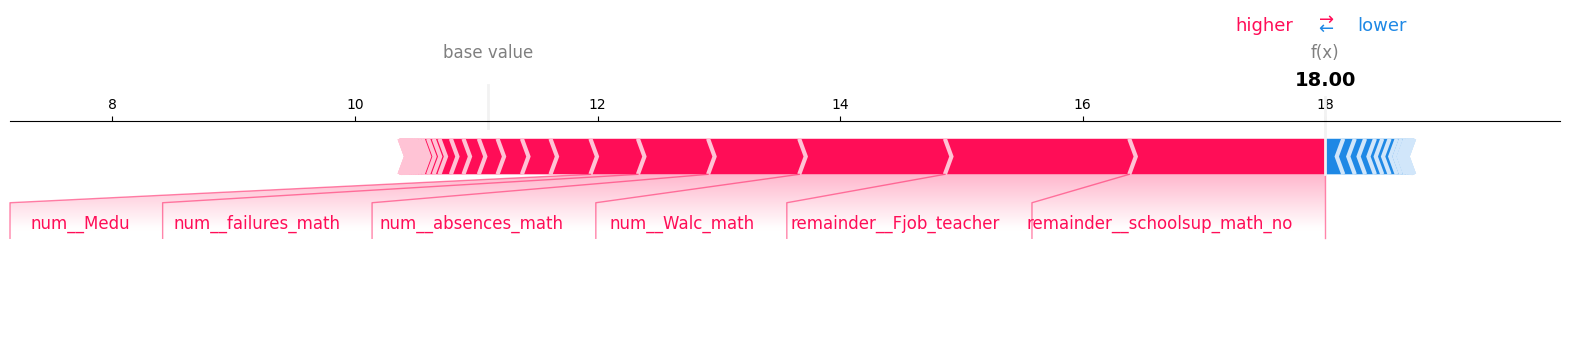

In [88]:
# SHAP Explanation for Random Forest Model on G3_por
target_names = y_test.columns
g3_por_index = list(target_names).index('G3_por')

g3_por_model = multi_output_forest.estimators_[g3_por_index]

explainer_por = shap.TreeExplainer(g3_por_model)

shap_values_por = explainer_por.shap_values(X_test_scaled)

feature_names = preprocessor.get_feature_names_out()

shap.initjs()
shap.plots.force(
    explainer_por.expected_value[0],
    shap_values_por[0, :, 0],
    feature_names=feature_names,
    matplotlib=True
)


Summary of feature impacts on all test set predictions:


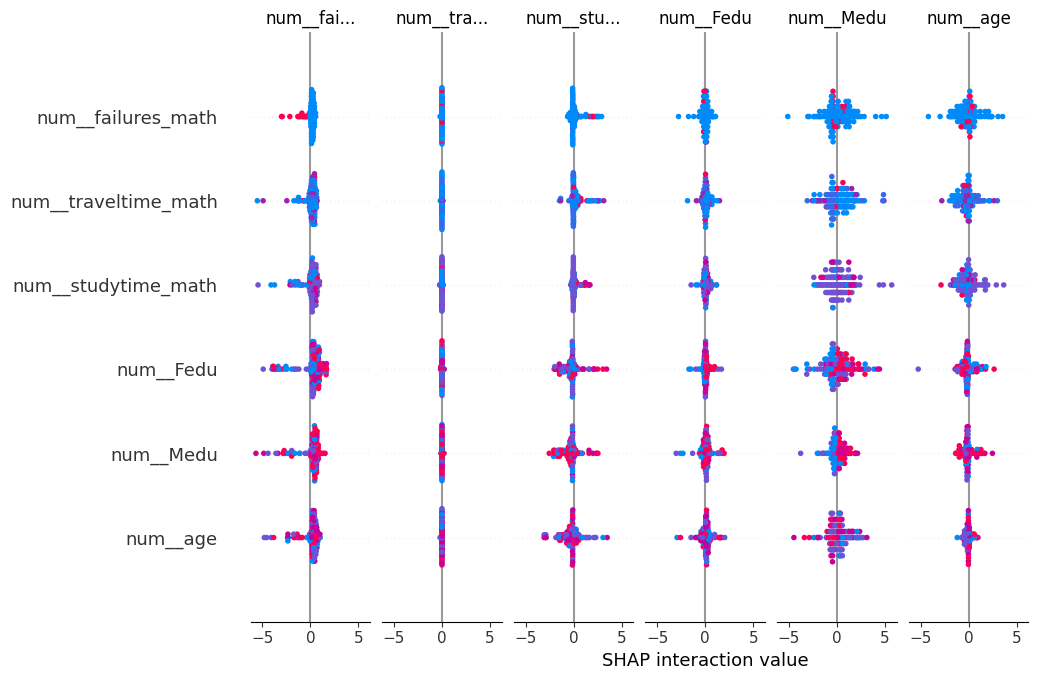

In [89]:
# SHAP Summary Plot
print(f"\nSummary of feature impacts on all test set predictions:")
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

In [90]:
# LIME Explanation for Random Forest Model on G3_math
predict_fn_g3_math = lambda x: multi_output_forest.predict(x)[:, g3_math_index]

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=feature_names,
    class_names=['G3_math'],
    mode='regression'
)

instance_to_explain = X_test_scaled[0]

print(f"Explaining prediction for the first student using LIME (G3_math):")
lime_explanation = lime_explainer.explain_instance(
    instance_to_explain,
    predict_fn_g3_math,
    num_features=10
)

exp_list = lime_explanation.as_list()

print(f"{'Feature':50s} {'Contribution':>12s}")
print("-"*65)

for feature, weight in exp_list:
    print(f"{feature:50s} {weight:>12.4f}")

predicted = round(multi_output_forest.predict([instance_to_explain])[0][g3_math_index], 2)
actual = y_test.iloc[0, g3_math_index]

print("\nPredicted G3_math:", predicted, "| Actual:", actual)

Explaining prediction for the first student using LIME (G3_math):
Feature                                            Contribution
-----------------------------------------------------------------
num__failures_math <= -0.33                              2.0012
num__studytime_math > 0.01                               0.4490
num__failures_por <= -0.37                              -0.3234
num__absences_math > 0.00                                0.3192
0.00 < remainder__schoolsup_math_no <= 1.00              0.2306
0.00 < remainder__higher_math_yes <= 1.00                0.2262
num__Fedu > 0.65                                         0.2245
remainder__Fjob_teacher > 0.00                           0.2096
num__Medu > 0.48                                         0.1926
remainder__higher_math_no <= 0.00                        0.1849

Predicted G3_math: 13.13 | Actual: 15.0


In [91]:
# LIME Explanation for Random Forest Model on G3_por
predict_fn_g3_por = lambda x: multi_output_forest.predict(x)[:, g3_por_index]

# LIME explainer (reuse if already created)
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=feature_names,
    class_names=['G3_por'],
    mode='regression'
)

instance_to_explain = X_test_scaled[0]

print(f"Explaining prediction for the first student using LIME (G3_por):")
lime_explanation_por = lime_explainer.explain_instance(
    instance_to_explain,
    predict_fn_g3_por,
    num_features=10
)

exp_list_por = lime_explanation_por.as_list()

print(f"{'Feature':50s} {'Contribution':>12s}")
print("-"*65)

for feature, weight in exp_list_por:
    print(f"{feature:50s} {weight:>12.4f}")

predicted_por = round(multi_output_forest.predict([instance_to_explain])[0][g3_por_index], 2)
actual_por = y_test.iloc[0, g3_por_index]

print("\nPredicted G3_por:", predicted_por, "| Actual:", actual_por)

Explaining prediction for the first student using LIME (G3_por):
Feature                                            Contribution
-----------------------------------------------------------------
num__failures_por <= -0.37                               2.3648
num__failures_math <= -0.33                              0.9776
remainder__school_MS <= 0.00                             0.5929
0.00 < remainder__schoolsup_math_no <= 1.00              0.4921
num__studytime_por > 0.12                                0.4135
num__studytime_math > 0.01                               0.4115
remainder__higher_por_no <= 0.00                         0.3479
num__Medu > 0.48                                         0.3093
remainder__Fjob_teacher > 0.00                           0.2906
num__Fedu > 0.65                                         0.2272

Predicted G3_por: 14.67 | Actual: 13.0
